<H1 style="color:blue">Import Libraries</H1>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import warnings
import pickle
import json
import os
from datetime import datetime

warnings.filterwarnings('ignore')

2025-07-29 20:03:16.624027: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753819396.919486      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753819397.008127      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<H1 style="color:blue">Dataset Laoding</H1>

In [2]:
# Create directory for saving models and artifacts
save_dir = 'model_artifacts'
os.makedirs(save_dir, exist_ok=True)

# Load and prepare data
data_path = "/kaggle/input/student-eligibility-dataset-100/sample_student_data.csv"
print(f"Loading dataset from: {data_path}")

# Load data
df = pd.read_csv(data_path)
print(f"Total Samples: {len(df)}")
print(f"Data shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# Display basic info
print("\nDataset Info:")
print(df.info())
print("\nTarget distribution:")
print(df['Decision'].value_counts())

# Map target variable
df['Decision'] = df['Decision'].map({'Eligible': 1, 'Not eligible': 0})

# Separate features and target
X = df.drop('Decision', axis=1)
y = df['Decision']

feature_names = X.columns.tolist()
num_features = X.shape[1]

print(f"\nNumber of features: {num_features}")
print(f"Feature names: {feature_names}")

Loading dataset from: /kaggle/input/student-eligibility-dataset-100/sample_student_data.csv
Total Samples: 1000
Data shape: (1000, 3)
Columns: ['Theory', 'Practice', 'Decision']

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Theory    1000 non-null   float64
 1   Practice  1000 non-null   float64
 2   Decision  1000 non-null   object 
dtypes: float64(2), object(1)
memory usage: 23.6+ KB
None

Target distribution:
Decision
Eligible        821
Not eligible    179
Name: count, dtype: int64

Number of features: 2
Feature names: ['Theory', 'Practice']


<H1 style="color:blue">Exploratory Data Analysis (EDA)</H1>

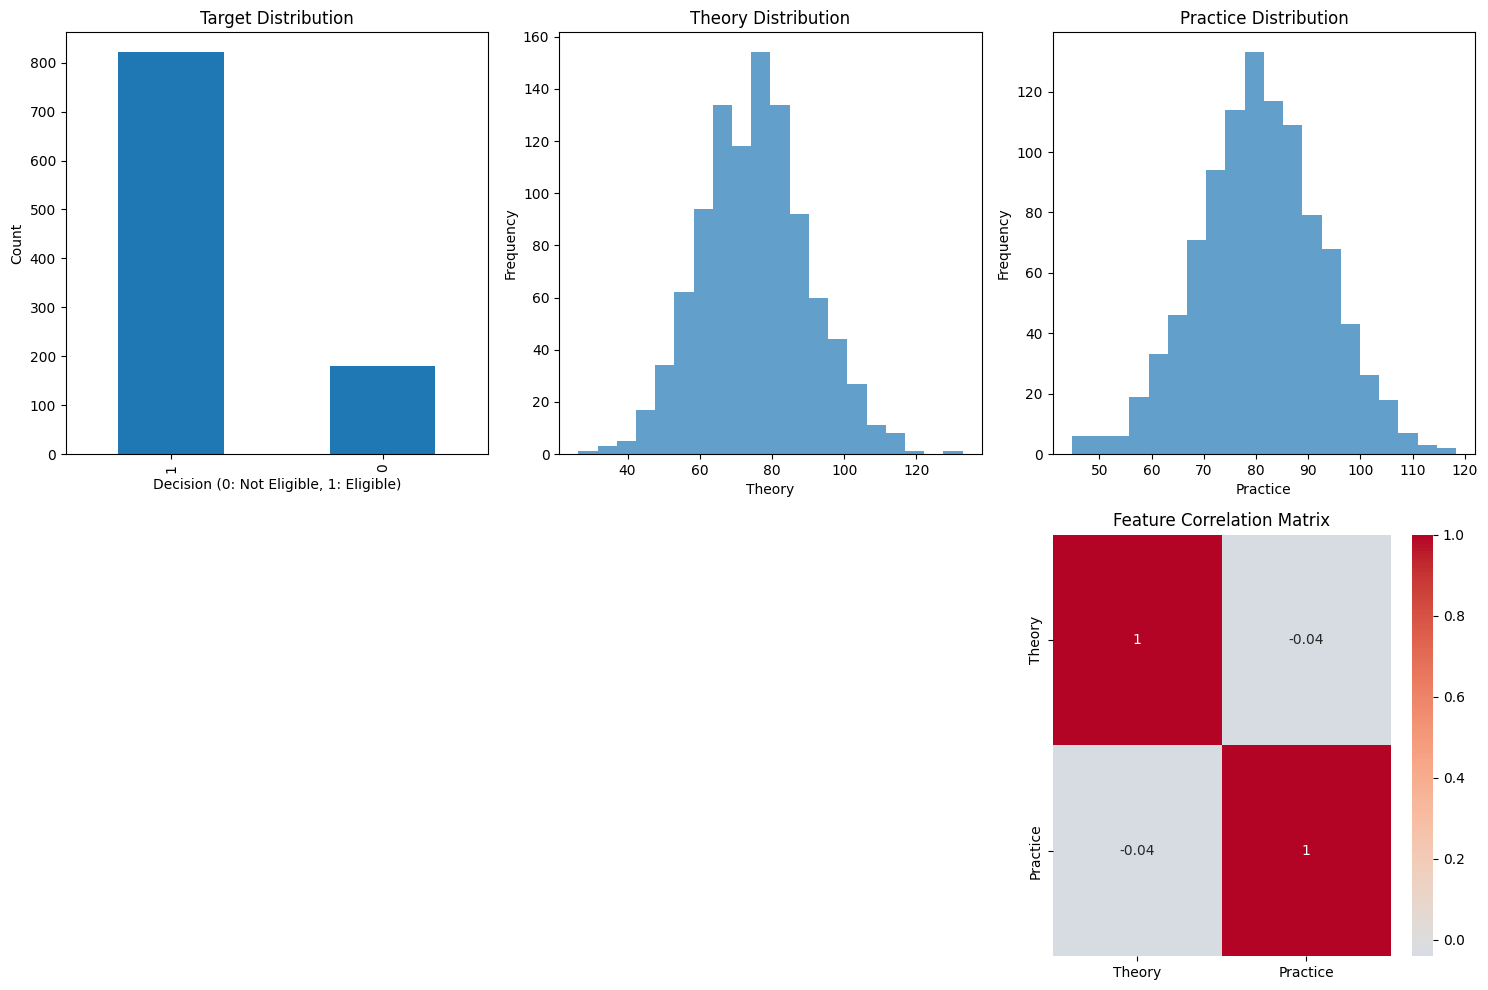

In [3]:

# Exploratory Data Analysis
plt.figure(figsize=(15, 10))

# Target distribution
plt.subplot(2, 3, 1)
y.value_counts().plot(kind='bar')
plt.title('Target Distribution')
plt.xlabel('Decision (0: Not Eligible, 1: Eligible)')
plt.ylabel('Count')

# Feature distributions
n_features = len(feature_names)
if n_features <= 4:
    for i, feature in enumerate(feature_names):
        plt.subplot(2, 3, i + 2)
        plt.hist(X[feature], bins=20, alpha=0.7)
        plt.title(f'{feature} Distribution')
        plt.xlabel(feature)
        plt.ylabel('Frequency')

# Correlation heatmap if multiple features
if n_features > 1:
    plt.subplot(2, 3, 6)
    correlation_matrix = X.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Matrix')

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'data_analysis.png'))
plt.show()

<H1 style="color:blue">Task for LO2 Starts from Here</H1>

<H1 style="color:blue">Dataset Splitting</H1>

In [4]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler for deployment
scaler_filename = os.path.join(save_dir, 'scaler.pkl')
with open(scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)

# Reshape for CNN (samples, timesteps, features)
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)


<H1 style="color:blue">Constructing CNN Model (CNN Network Architechure)</H1>

## 🧠 CNN Architecture Explanation

This Convolutional Neural Network (CNN) model is designed for binary classification tasks (e.g., determining if a student is eligible or not). Below is a breakdown of the architecture:

---

### 📥 **Input Layer**
- **Shape:** `(num_features, 1)`
- The input is reshaped to 3D format required by 1D CNNs, where each feature is treated as a "time step".

---

### 🧩 **Convolutional Layers**
- **Conv1D Layer 1**:  
  - Filters: 32  
  - Kernel Size: 2  
  - Activation: ReLU  
  - Padding: Same  
- **Batch Normalization**
- **Dropout**: 30% to prevent overfitting

- **Conv1D Layer 2**:  
  - Filters: 64  
  - Kernel Size: 2  
  - Activation: ReLU  
  - Padding: Same  
- **Batch Normalization**
- **MaxPooling1D**: Pool size = 1 (since the number of features is small)
- **Dropout**: 30%

---

### 🔄 **Flatten Layer**
- Flattens the 3D output to 1D to connect with fully connected (Dense) layers.

---

### 🔢 **Dense (Fully Connected) Layers**
- **Dense Layer 1**: 128 units + ReLU + BatchNorm + Dropout (40%)
- **Dense Layer 2**: 64 units + ReLU + Dropout (30%)

---

### 🎯 **Output Layer**
- **Dense(1)**:  
  - Activation: Sigmoid  
  - Outputs probability between 0 and 1 (for binary classification)

---

### ⚙️ **Compilation Settings**
- **Loss Function**: Binary Crossentropy  
- **Optimizer**: Adam (learning rate = 0.001)  
- **Metrics**: Accuracy

---

### 📝 Summary

This CNN model applies **1D convolutions** to extract patterns across features, followed by dense layers to classify the result. It uses regularization techniques such as **Dropout** and **Batch Normalization** to improve generalization and reduce overfitting.



In [5]:


# Build CNN model
input_shape = (num_features, 1)

if input_shape[0] <= 10:
    # Model for small feature sets
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(filters=32, kernel_size=2, activation='relu', padding='same'),
        BatchNormalization(),
        Dropout(0.3),
        
        Conv1D(filters=64, kernel_size=2, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=1),
        Dropout(0.3),
        
        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(64, activation='relu'),
        Dropout(0.3),
        
        Dense(1, activation='sigmoid')
    ])
else:
    # Model for larger feature sets
    model = Sequential([
        Input(shape=input_shape),
        
        # First convolutional block
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2 if input_shape[0] > 4 else 1),
        Dropout(0.25),
        
        # Second convolutional block
        Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2 if input_shape[0] > 8 else 1),
        Dropout(0.25),
        
        # Third convolutional block
        Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        Dropout(0.3),
        
        # Flatten and dense layers
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(128, activation='relu'),
        Dropout(0.3),
        
        # Output layer
        Dense(1, activation='sigmoid')
    ])

# Compile model
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Model Architecture:")
model.summary()

# Save model architecture to JSON
model_json = model.to_json()
with open(os.path.join(save_dir, 'model_architecture.json'), 'w') as json_file:
    json_file.write(model_json)

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Model checkpoint callback to save the best model
model_checkpoint = ModelCheckpoint(
    filepath=os.path.join(save_dir, 'best_model.h5'),
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

Model Architecture:


2025-07-29 20:03:35.000065: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2, 32)          │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2, 64)          │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,985 (117.13 KB)

 Trainable params: 29,537 (115.38 KB)

 Non-trainable params: 448 (1.75 KB)

<H1 style="color:blue">TRAIN CNN MODEL</H1>


Training model with 800 samples...
Epoch 1/100
13/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4401 - loss: 1.0386 
Epoch 1: val_loss improved from inf to 0.57529, saving model to model_artifacts/best_model.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.4891 - loss: 0.9510 - val_accuracy: 0.8125 - val_loss: 0.5753 - learning_rate: 0.0010
Epoch 2/100
13/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8401 - loss: 0.3904 
Epoch 2: val_loss improved from 0.57529 to 0.46227, saving model to model_artifacts/best_model.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8483 - loss: 0.3739 - val_accuracy: 0.8000 - val_loss: 0.4623 - learning_rate: 0.0010
Epoch 3/100
14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8850 - loss: 0.2648 
Epoch 3: val_loss improved from 0.46227 to 0.40014, saving model to model_artifacts/best_model.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8884 - loss: 0.2594 - val_accuracy: 0.8000 - val_loss: 0.4001 - learning_rate: 0.0

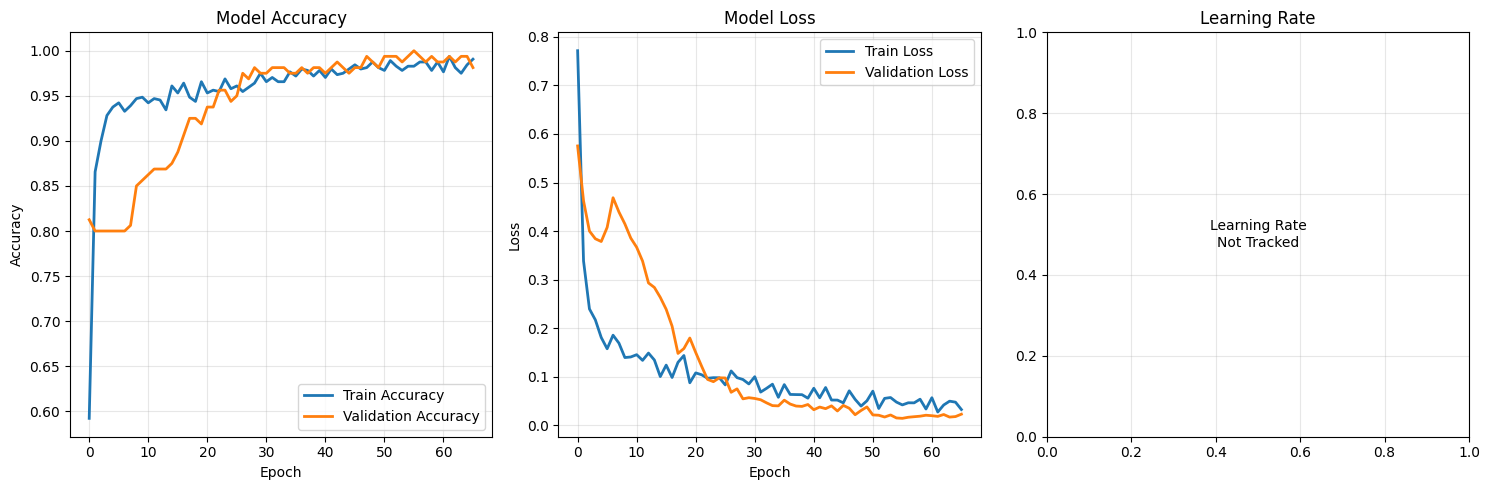

In [6]:
# Train model
print(f"\nTraining model with {X_train.shape[0]} samples...")
history = model.fit(
    X_train_reshaped, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr, model_checkpoint],
    verbose=1
)

# Save the final trained model
model.save(os.path.join(save_dir, 'final_model.h5'))

# Save training history
history_df = pd.DataFrame(history.history)
history_df.to_csv(os.path.join(save_dir, 'training_history.csv'), index=False)

# Plot training history
plt.figure(figsize=(15, 5))

# Accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, alpha=0.3)

# Loss
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, alpha=0.3)

# Learning rate (if available)
plt.subplot(1, 3, 3)
if 'lr' in history.history:
    plt.plot(history.history['lr'], linewidth=2)
    plt.title('Learning Rate')
    plt.ylabel('Learning Rate')
    plt.xlabel('Epoch')
    plt.yscale('log')
else:
    plt.text(0.5, 0.5, 'Learning Rate\nNot Tracked', 
            ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Learning Rate')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'training_history.png'))
plt.show()


<H1 style="color:blue">MODEL EVALUATION AND RESULTS INTERPRETATION</H1>

In [7]:

# Model Evaluation
print("\n" + "="*50)
print("MODEL EVALUATION")
print("="*50)

# Predictions
y_pred_proba = model.predict(X_test_reshaped)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()
print(y_pred)


MODEL EVALUATION
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[0 0 1 1 0 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0
 0 0 1 0 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0
 0 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1]


In [8]:
y_test

991    0
16     0
744    1
196    1
263    0
      ..
665    1
841    1
429    0
840    1
32     1
Name: Decision, Length: 200, dtype: int64

<H1 style="color:blue">Task No2. Ends Here</H1>

<H1 style="color:blue">Below practice refer to Task No3 (LO3)</H1>

Test Accuracy: 0.9950
Test Loss: 0.0140
AUC Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        36
           1       1.00      0.99      1.00       164

    accuracy                           0.99       200
   macro avg       0.99      1.00      0.99       200
weighted avg       1.00      0.99      1.00       200



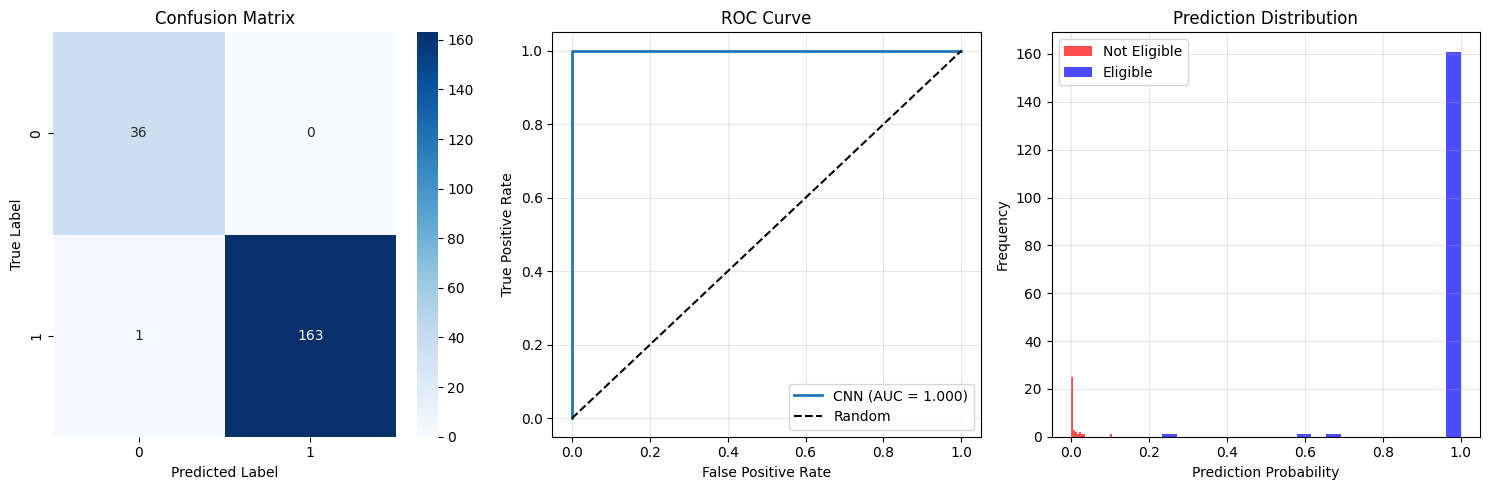


DETAILED EVALUATION


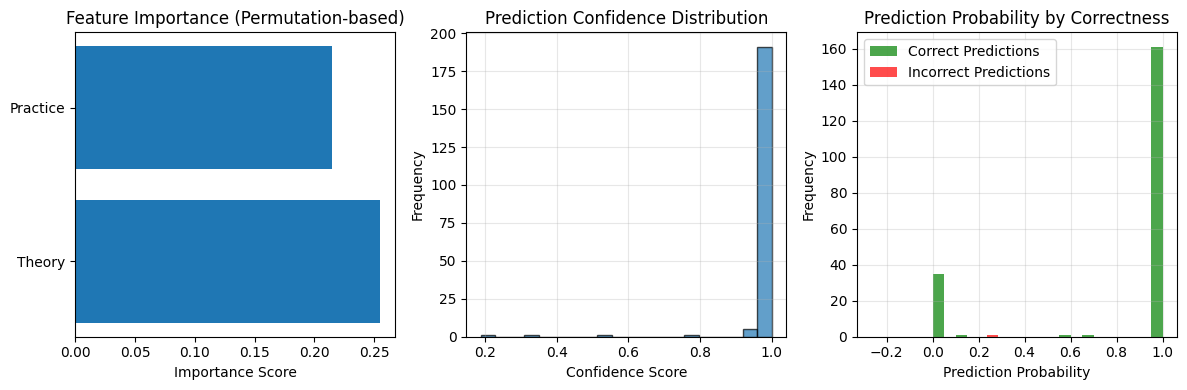


EXAMPLE PREDICTION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
New Student Scores: {'Theory': 85, 'Practice': 92}
Prediction: Eligible
Probability: 0.9998

MODEL TRAINING COMPLETE
All model artifacts saved to: model_artifacts


In [9]:

# Test accuracy
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# AUC Score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Save classification report
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(save_dir, 'classification_report.csv'))

# Plotting evaluation results
plt.figure(figsize=(15, 5))

# Confusion Matrix
plt.subplot(1, 3, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# ROC Curve
plt.subplot(1, 3, 2)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, linewidth=2, label=f'CNN (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True, alpha=0.3)

# Prediction Distribution
plt.subplot(1, 3, 3)
plt.hist(y_pred_proba[y_test == 0], bins=20, alpha=0.7, label='Not Eligible', color='red')
plt.hist(y_pred_proba[y_test == 1], bins=20, alpha=0.7, label='Eligible', color='blue')
plt.xlabel('Prediction Probability')
plt.ylabel('Frequency')
plt.title('Prediction Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'model_evaluation.png'))
plt.show()

# Detailed Evaluation
print("\n" + "="*50)
print("DETAILED EVALUATION")
print("="*50)

plt.figure(figsize=(12, 4))

# Feature importance (using permutation-like approach)
plt.subplot(1, 3, 1)
original_score = model.evaluate(X_test_reshaped, y_test, verbose=0)[1]
importances = []

for i in range(num_features):
    # Create noise for feature i
    X_test_noisy = X_test_reshaped.copy()
    np.random.shuffle(X_test_noisy[:, i, :])
    noisy_score = model.evaluate(X_test_noisy, y_test, verbose=0)[1]
    importance = original_score - noisy_score
    importances.append(max(0, importance))  # Keep positive values

plt.barh(feature_names, importances)
plt.title('Feature Importance (Permutation-based)')
plt.xlabel('Importance Score')

# Prediction confidence distribution
plt.subplot(1, 3, 2)
confidence = np.abs(y_pred_proba.flatten() - 0.5) * 2  # Convert to 0-1 confidence
plt.hist(confidence, bins=20, alpha=0.7, edgecolor='black')
plt.title('Prediction Confidence Distribution')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Error analysis
plt.subplot(1, 3, 3)
correct = (y_pred == y_test)
correct_proba = y_pred_proba[correct].flatten()
incorrect_proba = y_pred_proba[~correct].flatten()

plt.hist(correct_proba, bins=20, alpha=0.7, label='Correct Predictions', color='green')
plt.hist(incorrect_proba, bins=20, alpha=0.7, label='Incorrect Predictions', color='red')
plt.title('Prediction Probability by Correctness')
plt.xlabel('Prediction Probability')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'detailed_evaluation.png'))
plt.show()

# Save feature names and metadata
metadata = {
    'feature_names': feature_names,
    'target_classes': {0: 'Not eligible', 1: 'Eligible'},
    'input_shape': input_shape,
    'model_type': 'CNN',
    'creation_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'performance_metrics': {
        'test_accuracy': float(test_acc),
        'test_loss': float(test_loss),
        'auc_score': float(auc_score)
    }
}

with open(os.path.join(save_dir, 'metadata.json'), 'w') as f:
    json.dump(metadata, f, indent=4)

# Prediction function for new data
def predict_new_student(new_data_dict):
    """Predict eligibility for new student data"""
    # Convert to DataFrame
    new_data = pd.DataFrame([new_data_dict])
    
    # Ensure columns match training data
    if list(new_data.columns) != feature_names:
        print(f"Warning: Feature names don't match. Expected: {feature_names}")
    
    # Scale and reshape
    new_data_scaled = scaler.transform(new_data)
    new_data_reshaped = new_data_scaled.reshape(new_data_scaled.shape[0], new_data_scaled.shape[1], 1)
    
    # Predict
    probability = model.predict(new_data_reshaped)[0][0]
    prediction = "Eligible" if probability > 0.5 else "Not eligible"
    
    return probability, prediction

# Example prediction using actual feature names from the dataset
print("\n" + "="*50)
print("EXAMPLE PREDICTION")
print("="*50)

if len(feature_names) >= 2:
    # Use the actual feature names from the dataset for prediction
    new_student = {feature_names[0]: 85, feature_names[1]: 92}
    if len(feature_names) > 2:
        # Add more features if they exist in the dataset
        for i, feature in enumerate(feature_names[2:], 2):
            new_student[feature] = 80 + i * 2  # Sample values
else:
    # Fallback if only one feature
    new_student = {feature_names[0]: 85}

probability, prediction = predict_new_student(new_student)
print(f"New Student Scores: {new_student}")
print(f"Prediction: {prediction}")
print(f"Probability: {probability:.4f}")

print("\n" + "="*50)
print("MODEL TRAINING COMPLETE")
print("="*50)
print(f"All model artifacts saved to: {save_dir}")

<h1 style='color:blue'><a href='https://huggingface.co/spaces/ntam0001/deep_learning_cnn'>Click Deployed Model </a></h1>

In [12]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# import pickle
# import json
# import os

# # Create directory for saving models
# os.makedirs('model_artifacts1', exist_ok=True)

# # Load your dataset
# df = pd.read_csv('/kaggle/input/student-eligibility-dataset-100/sample_student_data.csv')

# # Preprocess data
# df['Decision'] = df['Decision'].map({'Eligible': 1, 'Not eligible': 0})
# X = df.drop('Decision', axis=1)
# y = df['Decision']

# # Split data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# # Standardize features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Save scaler
# with open('model_artifacts1/scaler.pkl', 'wb') as f:
#     pickle.dump(scaler, f)

# # Build a simpler model (DNN instead of CNN since we have few features)
# model = Sequential([
#     Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
#     BatchNormalization(),
#     Dropout(0.3),
    
#     Dense(128, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.3),
    
#     Dense(64, activation='relu'),
#     Dropout(0.2),
    
#     Dense(1, activation='sigmoid')
# ])

# # Compile model
# model.compile(optimizer=Adam(learning_rate=0.001),
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

# # Train model
# history = model.fit(X_train_scaled, y_train,
#                     epochs=50,
#                     batch_size=32,
#                     validation_split=0.2,
#                     callbacks=[
#                         EarlyStopping(patience=5, restore_best_weights=True),
#                         ModelCheckpoint('model_artifacts/best_model.h5', save_best_only=True)
#                     ])

# # Save model
# model.save('model_artifacts1/final_model.h5')

# # Save model architecture
# model_json = model.to_json()
# with open('model_artifacts1/model_architecture.json', 'w') as json_file:
#     json_file.write(model_json)

# # Save metadata
# metadata = {
#     'feature_names': X.columns.tolist(),
#     'target_classes': {0: 'Not eligible', 1: 'Eligible'},
#     'input_shape': [X_train_scaled.shape[1]]
# }

# with open('model_artifacts1/metadata.json', 'w') as f:
#     json.dump(metadata, f, indent=4)

# print("Model training complete. Artifacts saved to model_artifacts/")